# Impact of rainfall temporal distribution on flooding in Lin Dyke catchment


## Project Summary

Research suggests that the temporal distribution of rainfall within a storm event can influence the nature and severity of flooding resulting from that storm event....

Testing this using synthetic rainfall events derived from FEH/ReFH2. Standard profiles usually have one peak, testing three methods for splitting the total rainfall amount normally concentrated in this one peak into multiple peaks 

Analysing impact on the extent, depth and velocity of flooding, and the spatial distribution of these variables over the catchment

### Code initialisation

In [95]:
import os
from pathlib import Path
from PIL import Image
from my_functions_new import *

# Define whether to filter out values <0.1
remove_little_values = True

In [69]:
### Define the names of the methods, and the shorthand versions of the names used in the folder naming conventions
rainfall_scenario_names =  {'singlepeak' : 'sp', 'dividetime' : 'dt', 'subpeaktiming' : 'sp-t', 'maxspread': 'ms'}

In [76]:
# sp_depth_fp = "MeganModel/6hr_sp_u/6hr_singlepeak_depth.Resampled.Terrain.tif"
sp_fp = "MeganModel/6hr_sp_u/6hr_singlepeak_{}.Resampled.Terrain.tif"
fps = ["MeganModel/6hr_ms_u/6hr_maxspread_{}.Resampled.Terrain.tif",
       "MeganModel/6hr_sp-t_u/6hr_subpeaktiming_{}.Resampled.Terrain.tif",
       "MeganModel/6hr_dt_u/6hr_dividetime_{}.Resampled.Terrain.tif"]

In [71]:
breaks_difference = np.array([-0.1, 0.1, 0.3, 100])

#### Read in rasters containing depths and extents using each of the methods, and store these in a dictionary
#### Create versions of depth/velocity rasters which are classified into depth/velocity categories

In [72]:
breaks = np.array([0, 0.3, 0.6, 1.2, 100]) 
labels = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
classified_colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]

single_peak, out_meta = prepare_rainfall_scenario_raster(sp_depth_fp, remove_little_values)
singlepeak_classified = classify_raster(single_peak, breaks)
fp_for_classified_raster = 'HecRas_Processing' + '/' + sp_depth_fp.split('/')[1] + '/depth_classified.tif'
save_array_as_raster(singlepeak_classified, fp_for_classified_raster, out_meta) 
plot_classified_raster(fp_for_classified_raster, labels, classified_colors_list)

In [82]:

def plot_difference_levels_pos_neg (fp_for_posneg_diff_raster, norm = None):

    # Create discrete cmap
    colors_list = ["red", "grey", "green"]
    cmap = mpl.colors.ListedColormap(colors_list)

    # Create patches for legend
    patches_list = []
    labels= ['{} < single peak'.format(fp_for_posneg_diff_raster.split('/')[1]),
             '{} = single peak'.format(fp_for_posneg_diff_raster.split('/')[1]),
             '{} > single peak'.format(fp_for_posneg_diff_raster.split('/')[1])]
    for i, color in  enumerate(colors_list):
        patch =  mpatches.Patch(color=color, label=labels[i])
        patches_list.append(patch)  

    # plot the new clipped raster      
    clipped = rasterio.open(fp_for_posneg_diff_raster)

    # Set up plot instance
    fig, ax = plt.subplots(figsize=(20, 15))
    catchment_gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
    cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
    rasterio.plot.show((clipped, 1), ax= ax, cmap = cmap, norm = norm)

    # Close file (otherwise can't delete it, as ref to it is open)
    clipped.close()

    plt.axis('off')
    plt.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =15)
    
    # Create file path for saving figure to
    figs_dir = fp_for_posneg_diff_raster.split('/', 3)[0] + '/Figs/' + fp_for_posneg_diff_raster.split('/', 3)[1] +'/'
    Path(figs_dir).mkdir(parents=True, exist_ok=True)
    plot_fp = figs_dir + fp_for_posneg_diff_raster.split('/')[2].replace(".tif", ".png")
    
    # Save the figure
    plt.savefig(plot_fp, dpi=500,bbox_inches='tight')
    plt.close()  

In [83]:
def do_processing (variable_name):    
    
    ######################################################################################
    # Specify breaks and labels for this variable
    ######################################################################################
    if variable_name == 'depth':
        breaks = np.array([0, 0.3, 0.6, 1.2, 100])  
        labels = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
        classified_colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]
    elif variable_name == 'velocity':
        breaks = np.array([0,0.25,0.5,2,100])
        labels = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]
        classified_colors_list = [mpl.cm.cool(0.3), mpl.cm.cool(0.5), mpl.cm.cool(0.7), mpl.cm.cool(0.9)]
        
    ######################################################################################
    # For the single peak scenarios:
        # Classify depth/velocity rasters into depth/velocity bins
        # Save as raster
        # Plot this raster, and save the output
    ######################################################################################
    single_peak, out_meta = prepare_rainfall_scenario_raster(sp_fp.format(variable_name), remove_little_values)
    singlepeak_classified = classify_raster(single_peak, breaks)
    fp_for_classified_raster = 'HecRas_Processing' + '/' + sp_depth_fp.split('/')[1] + '/{}_classified.tif'.format(variable_name)
    save_array_as_raster(singlepeak_classified, fp_for_classified_raster, out_meta) 
    plot_classified_raster(fp_for_classified_raster, labels, classified_colors_list)
    
    ######################################################################################
    # For the other rainfall scenarios:
        # Classify depth/velocity rasters into depth/velocity bins
            # Save as raster
            # Plot this raster, and save the output
        # Find the difference between depth/velocity rasters for this scenario and the single peak scenario:
            # Save this as a raster
            # Plot this raster and save the output
        # Reclassify the difference rasters into bins:
            # Save this as a raster
            # Plot this raster and save the output
        # Reclassify the difference rasters into positive, negative or neutral differences:
            # Save this as a raster
            # Plot this raster and save the output
    ######################################################################################
    for fp in fps:
        print(fp.format(variable_name))
        
        # Create directory to store results
        processing_dir = "HecRas_Processing/" + fp.split('/')[1]
        Path(processing_dir).mkdir(parents=True, exist_ok=True)
    
        # Classify depth/velocity rasters into depth/velocity bins
        this_scenario_raster = prepare_rainfall_scenario_raster(fp.format(variable_name), remove_little_values)[0]
        this_scenario_classified = classify_raster(this_scenario_raster, breaks)
        fp_for_classified_raster = 'HecRas_Processing' + '/' + fp.format(variable_name).split('/')[1] + '/{}_classified.tif'.format(variable_name)
        save_array_as_raster(this_scenario_classified, fp_for_classified_raster, out_meta) 
        plot_classified_raster(fp_for_classified_raster, labels, classified_colors_list)    

        # Find difference between depth/velocity rasters from this method, and the single peak method
        difference_raster = single_peak - this_scenario_raster
        #fp_for_difference_raster = "Arcpy/{}_singlepeak_{}_diff.tif".format(variable_name, rainfall_scenario_name)
        #save_array_as_raster(singlepeak_classified, fp_for_difference_raster, out_meta) 
        #plot_difference(variable_name, rainfall_scenario_name, labels, 'YlGnBu') 

        # Reclassify the difference rasters to categories 
        classified_difference_raster = classify_raster (difference_raster, breaks_difference)
        fp_for_classified_diff_raster = 'HecRas_Processing' + '/' + fp.format(variable_name).split('/')[1] + '/{}_difffromsinglepeak_classified.tif'.format(variable_name)
        save_array_as_raster(classified_difference_raster, fp_for_classified_diff_raster, out_meta) 
        plot_difference_levels(fp_for_classified_diff_raster, labels)    

        # Reclassify the difference rasters to represent whether value is positive or negative 
        pos_neg_depth_diff = np.where((np.isnan(difference_raster)), np.nan, 
                                  np.where((difference_raster > 0), 0,
                                    np.where((difference_raster == 0), 1,
                                        np.where((difference_raster < 0), 2, 500))))
        fp_for_posneg_diff_raster = 'HecRas_Processing' + '/' + fp.format(variable_name).split('/')[1] + '/{}_difffromsinglepeak_posneg.tif'.format(variable_name)
        save_array_as_raster(pos_neg_depth_diff, fp_for_posneg_diff_raster, out_meta) 
        plot_difference_levels_pos_neg(fp_for_posneg_diff_raster)  

        
# Run the function  
do_processing('depth') 
do_processing('velocity')

MeganModel/6hr_ms_u/6hr_maxspread_depth.Resampled.Terrain.tif
MeganModel/6hr_sp-t_u/6hr_subpeaktiming_depth.Resampled.Terrain.tif
MeganModel/6hr_dt_u/6hr_dividetime_depth.Resampled.Terrain.tif
MeganModel/6hr_ms_u/6hr_maxspread_velocity.Resampled.Terrain.tif
MeganModel/6hr_sp-t_u/6hr_subpeaktiming_velocity.Resampled.Terrain.tif
MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif


In [ ]:
# Define breaks to split the depths/velocities on
breaks_depths = np.array([0, 0.3, 0.6, 1.2, 100])  
labels_depth = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

velocity_counts, velocity_props = create_binned_counts_and_props(rainfall_scenario_names, 'velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts, depth_props = create_binned_counts_and_props(rainfall_scenario_names, 'depth', breaks_depths, labels_depth, remove_little_values)

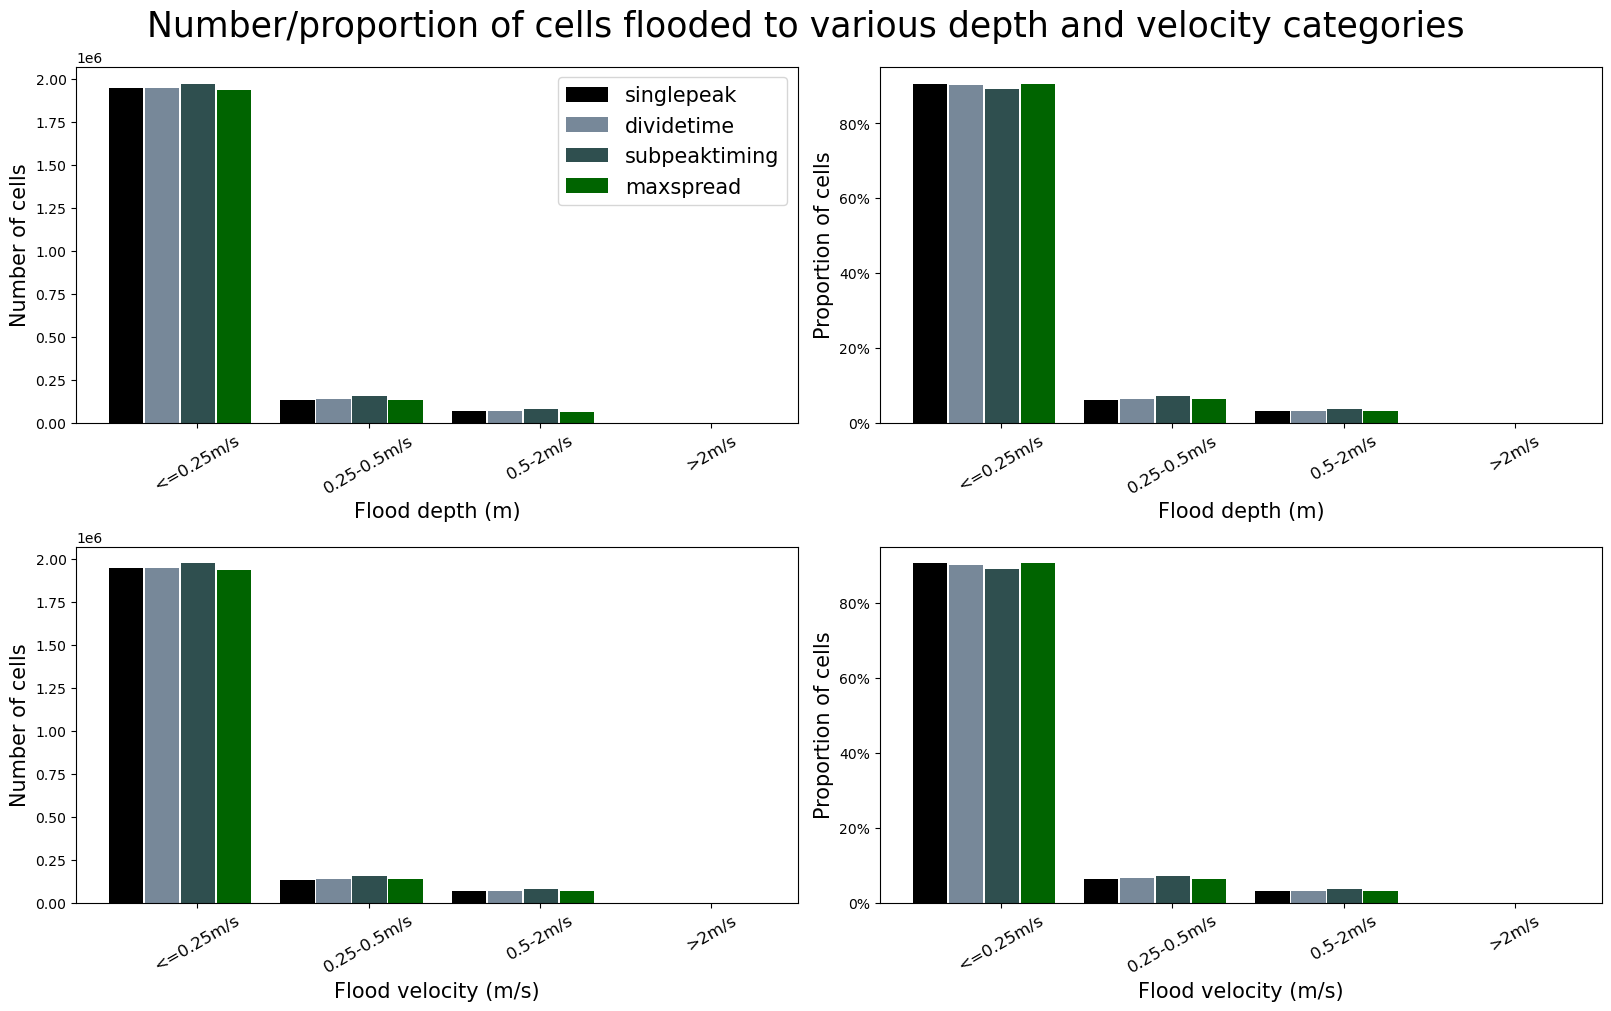

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize = (16,10))
fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222, 223, 224]
subplot_i = 0

colors = ['black', 'lightslategrey', 'darkslategrey', 'darkgreen']
units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):
    
    # Create...
    counts_df, props_df = create_binned_counts_and_props(rainfall_scenario_names, 'velocity', breaks_velocity, labels_velocity)
    
    ################# Plot
    labels = counts_df['index']
    x = np.arange(len(counts_df['index']))
    width = 0.3
    
    # counts_df plotting
    width, DistBetweenBars, Num = 0.2, 0.01, 4 # width of each bar, distance between bars, number of bars in a group
    # calculate the width of the grouped bars (including the distance between the individual bars)
    WithGroupedBars = Num*width + (Num-1)*DistBetweenBars
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, counts_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(counts_df['index'])), counts_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Number of cells', fontsize = 15)
    # Put legend on top left plot
    if subplot_i == 0:
        plt.legend(counts_df.columns[1:], fontsize=15, frameon = True)
   
    # Proportions_df plotting
    subplot_i = subplot_i+ 1        
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, props_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(props_df['index'])), props_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Proportion of cells', fontsize = 15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    subplot_i = subplot_i+ 1 


In [93]:
fps = ["MeganModel/6hr_ms_u/6hr_maxspread_{}.Resampled.Terrain.tif",
       "MeganModel/6hr_sp-t_u/6hr_subpeaktiming_{}.Resampled.Terrain.tif",
       "MeganModel/6hr_dt_u/6hr_dividetime_{}.Resampled.Terrain.tif"]

    
figs_dir = 'Hecras_Processsing/Figs/' + fp.split('/')[1] +'/'
figs_dir
# fp.split('/')[1] +'/'
#     Path(figs_dir).mkdir(parents=True, exist_ok=True)
#     plot_fp = figs_dir + fp_for_posneg_diff_raster.split('/')[2].replace(".tif", ".png")

'Hecras_Processsing/Figs/6hr_dt_u/'

In [98]:
os.getcwd()

'/nfs/a319/gy17m2a/PhD/FloodModelling'

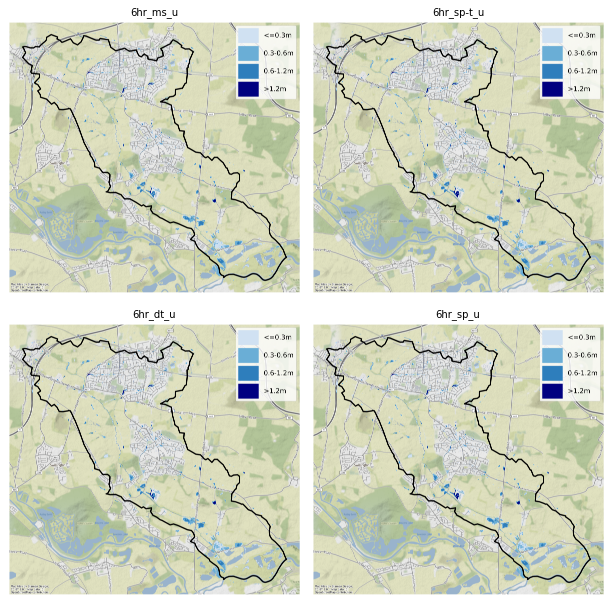

In [107]:
#Spatial extent of flooding, by depth category (for d >0.1m) for each rainfall distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,20))
subplot_n = [221, 222, 223, 224]
subplot_i = 0
fps+[sp_fp]
     
for subplot_i, fp in enumerate(fps+[sp_fp]):
    img = Image.open('HecRas_Processing/Figs/' + fp.split('/')[1] +'/depth_classified.png')
    plt.subplot(subplot_n[subplot_i])
    plt.axis('off')
    plt.imshow(img)
    plt.title(fp.split('/')[1], fontsize = 10)
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.4, hspace=0.1)
plt.show()    